In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class Slide:

    def __init__(self, center, width, length, orientation):
        self.center = center
        self.length = length
        self.width = width
        self.orientation = orientation

        # Calculate the corners of the slide
        self.corners = np.array([[self.center[0]-self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]+self.length/2],
                                [self.center[0]-self.width/2, self.center[1]+self.length/2]])
        # Transform the corners according to the orientation
        theta = np.deg2rad(self.orientation)
        # Rotate corner about slide center
        T = np.array([[np.cos(theta), -np.sin(theta), self.center[0] - self.center[0]*np.cos(theta) + self.center[1]*np.sin(theta)],
                        [np.sin(theta), np.cos(theta), self.center[1] - self.center[0]*np.sin(theta) - self.center[1]*np.cos(theta)],
                        [0, 0, 1]])
        for i in range(len(self.corners)):
            self.corners[i] = np.matmul(T, np.append(self.corners[i], 1))[:2]

        # Calculate the corners of the slide
        self.bottom_left = self.corners[0]
        self.bottom_right = self.corners[1]
        self.top_right = self.corners[2]
        self.top_left = self.corners[3]

    def contains(self, x, y):
        return self.point_in_triangle(x, y, self.bottom_left, self.bottom_right, self.top_right) or \
                self.point_in_triangle(x, y, self.bottom_left, self.top_right, self.top_left)

    def point_in_triangle(self, x, y, p1, p2, p3):
        # Check if the point is within the triangle using barycentric coordinates
        s = (p1[1]*p3[0] - p1[0]*p3[1] + (p3[1] - p1[1])*x + (p1[0] - p3[0])*y) / \
            (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

        t = (p1[0]*p2[1] - p1[1]*p2[0] + (p1[1] - p2[1])*x + (p2[0] - p1[0])*y) / \
            (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

        return (s > 0) & (t > 0) & (1 - s - t > 0)

Area difference:  78461.27652340509
Rect area:  1875
Max rects:  42


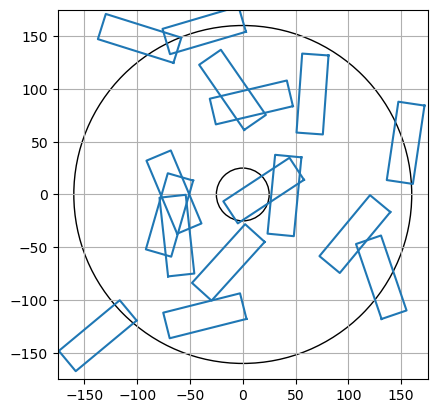

In [35]:
RADIUS_OUT = 160
RADIUS_IN = 25
SLIDE_WIDTH = 25
SLIDE_LENGTH = 75
SEP = 3

# Make circles
circle_out = plt.Circle((0, 0), RADIUS_OUT, edgecolor='black', facecolor='none')
circle_in = plt.Circle((0, 0), RADIUS_IN, edgecolor='black', facecolor='none')

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.add_artist(circle_out)
ax.add_artist(circle_in)
ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid(True)

# Area difference
area_diff = np.pi * (RADIUS_OUT**2 - RADIUS_IN**2)
print("Area difference: ", area_diff)
rect_area = SLIDE_WIDTH * SLIDE_LENGTH
print("Rect area: ", rect_area)
max_rects = area_diff / rect_area
print("Max rects: ", round(max_rects))

NUM_RECTS = 16
rect_centers = np.random.uniform(-RADIUS_OUT, RADIUS_OUT, size=(NUM_RECTS, 2))
rect_orientations = np.random.uniform(0, 179, size=NUM_RECTS)
rect_poses = np.hstack((rect_centers, rect_orientations.reshape(-1, 1)))
rects = []
for i in range(NUM_RECTS):
    rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')

plt.show()

16
Overlap area:  1380.4140253180524
OOB area:  5960.682028498167
Total area:  7341.096053816219


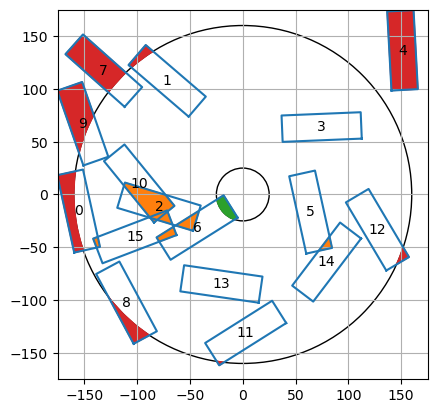

In [96]:
from shapely.geometry import Polygon, Point, MultiPolygon

# Perform gradient descent to minimise overlapping area
NUM_RECTS = 16
rect_centers = np.random.uniform(-RADIUS_OUT, RADIUS_OUT, size=(NUM_RECTS, 2))
rect_orientations = np.random.uniform(0, 179, size=NUM_RECTS)
rect_poses = np.hstack((rect_centers, rect_orientations.reshape(-1, 1)))

# Make circles
circle_out = plt.Circle((0, 0), RADIUS_OUT, edgecolor='black', facecolor='none')
circle_in = plt.Circle((0, 0), RADIUS_IN, edgecolor='black', facecolor='none')

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.add_artist(circle_out)
ax.add_artist(circle_in)
ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid(True)

def get_overlap_area(rects):
    # Calculate the area of overlap between all rectangles
    overlap_area = 0
    for i in range(len(rects)):
        for j in range(i+1, len(rects)):
            p1 = Polygon(rects[i].corners)
            p2 = Polygon(rects[j].corners)
            overlap = p1.intersection(p2)
            if overlap.area > 0:
                overlap_area += overlap.area
                ax.fill(*overlap.exterior.xy, c='C1')
    oob_area = 0
    for i in range(len(rects)):
        c1 = Point(0,0).buffer(RADIUS_IN)
        c2 = Point(0,0).buffer(RADIUS_OUT)
        p = Polygon(rects[i].corners)
        overlap1 = p.intersection(c1)
        overlap2 = p.difference(c2)
        if overlap1.area > 0:
            oob_area += overlap1.area
            ax.fill(*overlap1.exterior.xy, c='C2')
        if overlap2.area > 0:
            oob_area += overlap2.area
            ax.fill(*overlap2.exterior.xy, c='C3')

    return overlap_area, oob_area

rects = []
for i in range(NUM_RECTS):
    rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')
    ax.annotate(i, (rects[i].center[0], rects[i].center[1]), ha='center', va='center')
print(len(rects))

overlap_area, oob_area = get_overlap_area(rects)
print("Overlap area: ", overlap_area)
print("OOB area: ", oob_area)
print("Total area: ", overlap_area + oob_area)

Overlapping area: 2.352411367909454


(-0.1, 2.1, -0.1, 2.1)

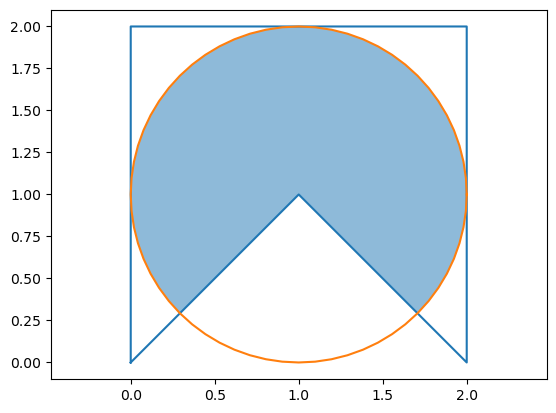

In [33]:
from shapely.geometry import Polygon, Point

# Create a polygon as the other geometry
polygon = Polygon([(0, 0), (0, 2), (2, 2), (2, 0), (1, 1)])

# Create a circle as the second geometry
center = Point(1, 1)  # Center coordinates of the circle
radius = 1  # Radius of the circle

# Create a buffer around the point to represent the circle
circle = center.buffer(radius)

# Find the overlapping area
overlapping_area = polygon.intersection(circle)

# Calculate the area
area_value = overlapping_area.area

print(f"Overlapping area: {area_value}")

plt.plot(*polygon.exterior.xy)
plt.plot(*circle.exterior.xy)
plt.fill(*overlapping_area.exterior.xy, alpha=0.5)
plt.axis('equal')

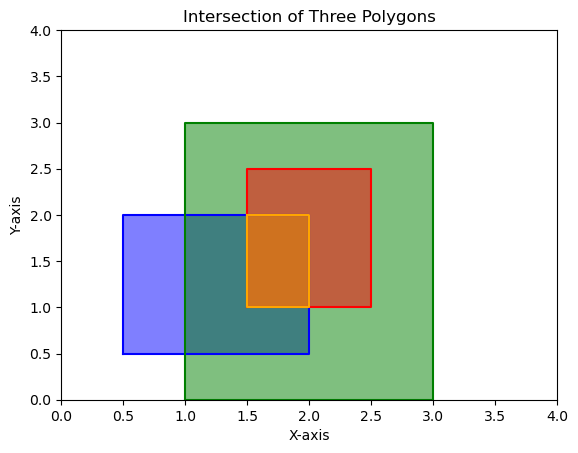

In [44]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Create three example polygons
polygon1 = Polygon([(0.5, 0.5), (0.5, 2), (2, 2), (2, 0.5)])
polygon2 = Polygon([(1, 0), (1, 3), (3, 3), (3, 0)])
polygon3 = Polygon([(1.5, 1), (1.5, 2.5), (2.5, 2.5), (2.5, 1)])

# Calculate the total intersection area
intersection_area = polygon1.union(polygon2).union(polygon3).area

# Plot the polygons and intersection area
fig, ax = plt.subplots()

# Plot polygon 1
x, y = polygon1.exterior.xy
ax.fill(x, y, facecolor='blue', alpha=0.5)
ax.plot(x, y, c='blue')

# Plot polygon 2
x, y = polygon2.exterior.xy
ax.fill(x, y, facecolor='green', alpha=0.5)
ax.plot(x, y, c='green')

# Plot polygon 3
x, y = polygon3.exterior.xy
ax.fill(x, y, facecolor='red', alpha=0.5)
ax.plot(x, y, c='red')

# Calculate the intersection polygon
intersection_polygon = polygon1.intersection(polygon2).intersection(polygon3)
x, y = intersection_polygon.exterior.xy
ax.fill(x, y, facecolor='orange', alpha=0.5)
ax.plot(x, y, c='orange')

# Set plot limits
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

# Add title and labels
ax.set_title('Intersection of Three Polygons')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()
